In [92]:
# Importing dependencies and libraries
import numpy as np
import json
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.stats as st
import os

from config import api_key
from citipy import citipy
from IPython.display import clear_output

In [93]:
# Building the 500+ cities list

# Setting ranges to look for cities
latitude_range = np.random.randint(-90,91, 70) #change 10 to 70 when testing is done
longitude_range = np.random.randint(-180,181, 70) #change 10 to 70 when testing is done

# This loop will ensure that the sample size is enough
# At least 500 (will do 550 just to be sure) cities with data are needed, 
# with a 5.8% of missing data 577 cities is the minimum sample size
test = False
while test == False:

    cities_list = []
    #nested for loop that will retrieve every city
    for x in longitude_range:
        for y in latitude_range:
            city = citipy.nearest_city(x,y)
            cities_list.append(city.city_name)
    if len(cities_list) >= 577: #change conditional to 577 after testing
        test = True
#converting the resulting list to a dataframe, dropping the duplicates and reindexing
cities_list_df = pd.DataFrame({'Cities':cities_list})
cities_list_df = cities_list_df.drop_duplicates().reset_index(drop = True)
print(f'Sample size is {len(cities_list_df.index)} list built succesfully')
cities_list_df.head(10)

Sample size is 686 list built succesfully


,Cities
0,sorland
1,tromso
2,dikson
3,klaksvik
4,belushya guba
5,clyde river
6,dudinka
7,yar-sale
8,upernavik
9,tasiilaq


In [94]:
#API requests

# Lists initialization
latitude = []
longitude = []
temperature = []
humidity = []
cloudiness = []
wind = []
failed_cities = []

# Base URL
url = "http://api.openweathermap.org/data/2.5/weather?"

# Variable initialization for progress tracker
request_num = 0
succ_request = 0
failed_request = 0

# for loop to request data from all cities
for city in cities_list_df['Cities']:
    
    # Build query URL
    query_url = url + "appid=" + api_key + "&q=" + city + "&units=imperial"
    
    # Request data for the current city
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()
    
    # Printing progress information
    clear_output(wait=True)
    request_num += 1
    print(f'Processing request {request_num}/{len(cities_list_df.index)} City: {city}')
    print(f'{succ_request} succesfull {failed_request} failed')
    
    # Making sure the request was succesful
    if weather_response.status_code == 200:
        # Appending current data to lists
        latitude.append(weather_json['coord']['lat'])
        longitude.append(weather_json['coord']['lon'])
        temperature.append(weather_json['main']['temp'])
        humidity.append(weather_json['main']['humidity'])
        cloudiness.append(weather_json['clouds']['all'])
        wind.append(weather_json['wind']['speed'])
        succ_request += 1
    else:
        failed_request += 1
        # Saving the failed city to be able to delete it from the dataframe
        failed_cities.append(city)
    
    # Making sure that time between requests is enough so that API key doesn't get blocked
    time.sleep(1.01)

# Print out final request results
clear_output(wait=True)   
print('API requests finished')
print(f'{succ_request} succesfull {failed_request} failed')


API requests finished
642 succesfull 44 failed


In [95]:
# Cleanind and building the results dataframe

clean_weather_df = cities_list_df.copy(deep=True)

# Deleting the cities with missing values
for city in failed_cities:
    # Finding the row to delete
    row_index = clean_weather_df.loc[clean_weather_df['Cities'] == city, :].index
    clean_weather_df.drop(row_index, inplace = True, axis = 0)

# Appending the data retrieved
clean_weather_df['Latitude'] = latitude
clean_weather_df['Longitude'] = longitude
clean_weather_df['Temperature (°F)'] = temperature
clean_weather_df['Humidity'] = humidity
clean_weather_df['Cloudiness'] = cloudiness
clean_weather_df['Wind Speed (mph)']= wind

clean_weather_df = clean_weather_df.reset_index(drop = True)

#saving the information dataframe to a csv file
path = os.path.join('resources', 'weather_data.csv')
clean_weather_df.to_csv(path)

clean_weather_df.head(10)


,Cities,Latitude,Longitude,Temperature (°F),Humidity,Cloudiness,Wind Speed (mph)
0,sorland,67.6670,12.6934,36.54,59,100,21.39
1,tromso,69.6496,18.9570,28.18,93,40,3.44
2,dikson,73.5069,80.5464,32.20,97,100,18.57
3,klaksvik,62.2266,-6.5890,42.80,100,40,5.75
4,clyde river,70.4692,-68.5914,17.60,100,90,5.75
5,dudinka,69.4058,86.1778,31.75,98,100,18.37
6,yar-sale,66.8333,70.8333,34.07,99,100,10.22
7,upernavik,72.7868,-56.1549,31.51,79,100,5.99
8,tasiilaq,65.6145,-37.6368,37.40,48,75,4.61
9,ilulissat,69.2167,-51.1000,37.40,65,100,2.30


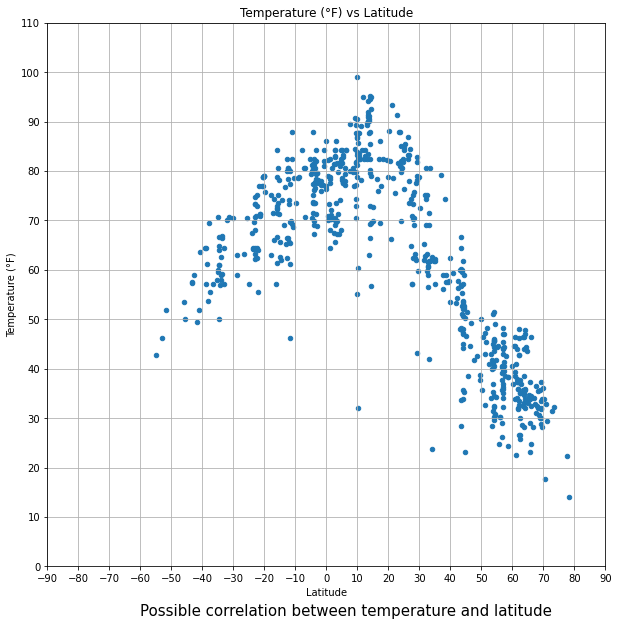

In [102]:
# Plotting Temperature (F) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis will contain max/min temperature values rounded to the closest 10
min_temp = (round(clean_weather_df['Temperature (°F)'].min()/10, 0))*10 - 10
max_temp = (round(clean_weather_df['Temperature (°F)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp+10, 10)

# Plotting
clean_weather_df.plot(kind="scatter", x="Latitude", y="Temperature (°F)", grid=True, figsize=(10,10),
                  title="Temperature (°F) vs Latitude", xticks= xticks, yticks= yticks)

# Adding an explanatory line for the graph
plt.annotate("Possible correlation between temperature and latitude", xy=(-60,-10), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'temp_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)


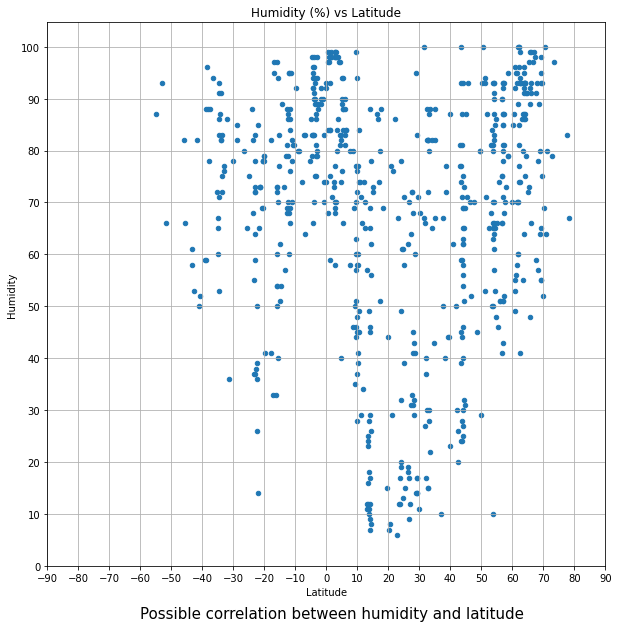

In [103]:
# Plotting Humidity (%) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis is a percentage will go from 0 to 100 always
yticks = np.arange(0,110,10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Humidity", grid=True, figsize=(10,10),
                  title="Humidity (%) vs Latitude", xticks= xticks, yticks= yticks)

# Adding an explanatory line for the graph
plt.annotate("Possible correlation between humidity and latitude", xy=(-60,-10), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'hum_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)

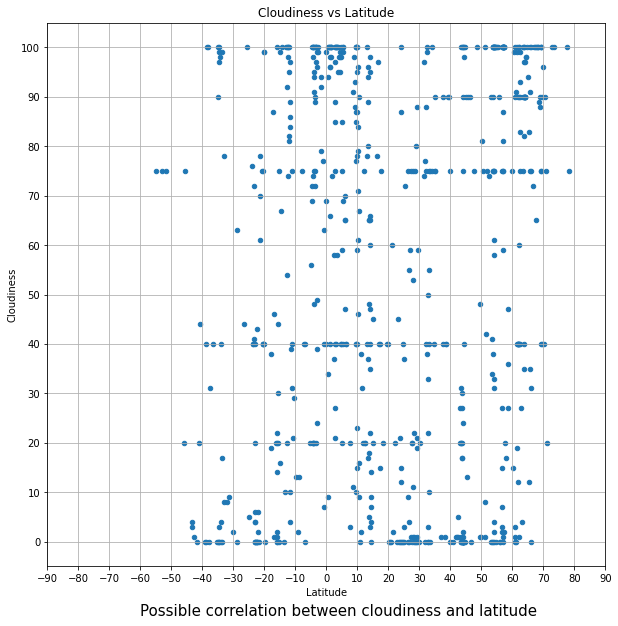

In [104]:
# Plotting Cloudiness (%) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis is a percentage will go from 0 to 100, but cloudiness can go to 100%, will adjust the axis to 105
yticks = np.arange(0,105,10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Cloudiness", grid=True, figsize=(10,10),
                  title="Cloudiness vs Latitude", xticks= xticks, yticks= yticks)

# Adding an explanatory line for the graph
plt.annotate("Possible correlation between cloudiness and latitude", xy=(-60,-15), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'cloud_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)


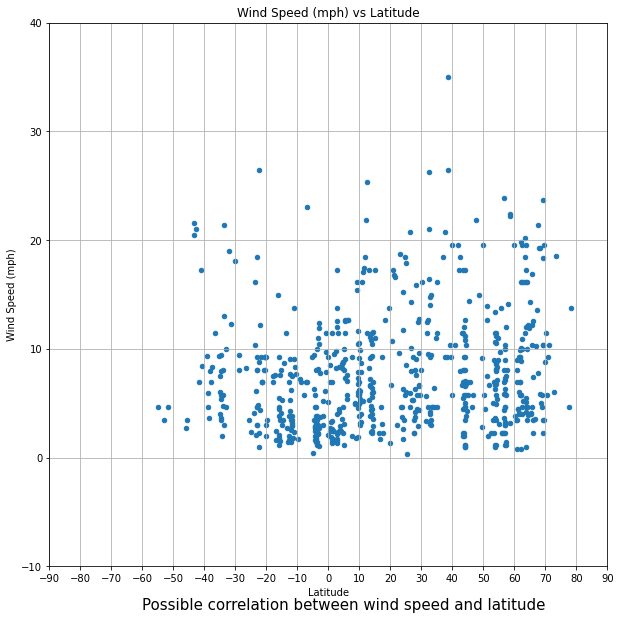

In [105]:
# Plotting Wind Speed (mph) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis will contain max/min wind speed values rounded to the closest 10
min_wind = (round(clean_weather_df['Wind Speed (mph)'].min()/10, 0))*10 - 10
max_wind = (round(clean_weather_df['Wind Speed (mph)'].max()/10,0))*10 + 10
yticks = np.arange(min_wind, max_wind, 10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Wind Speed (mph)", grid=True, figsize=(10,10),
                  title="Wind Speed (mph) vs Latitude", xticks= xticks, yticks= yticks)

# Adding an explanatory line for the graph
plt.annotate("Possible correlation between wind speed and latitude", xy=(-60,-14), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'wind_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)


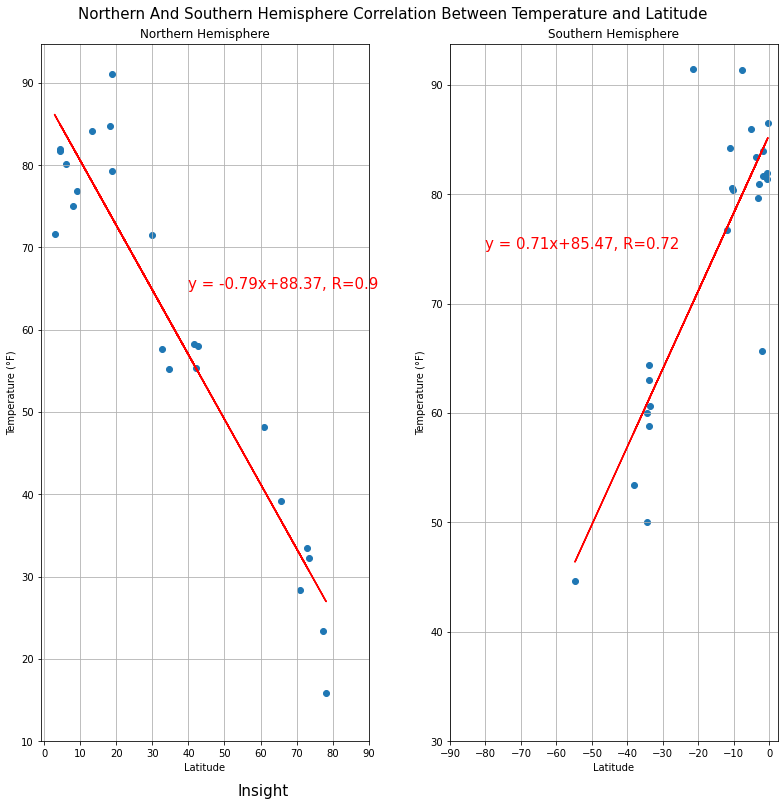

In [79]:
# Temperature (F) vs. Latitude broken by hemisphere

# Splitting the dataframe into north and south hemisphere
north_df = clean_weather_df.loc[clean_weather_df['Latitude'] >= 0]
south_df = clean_weather_df.loc[clean_weather_df['Latitude'] < 0]

## North hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(0,100,10)

# Y axis will contain max/min temp values rounded to the closest 10
min_temp = (round(clean_weather_df['Temperature (°F)'].min()/10, 0))*10 - 10
max_temp = (round(clean_weather_df['Temperature (°F)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp, 10)

# Setting x and y for line
x_values = north_df['Latitude']
y_values = north_df['Temperature (°F)']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

# Plotting
fig, axes =plt.subplots(1,2,figsize=(11,11))

axes[0].scatter(x=north_df["Latitude"], y=north_df["Temperature (°F)"])
axes[0].grid()
axes[0].annotate(line_eq + ', R=' + str(round(r**2, 2)),(40,65), fontsize=15,color="red")
axes[0].plot(x_values, m*x_values + b, color ='r')
axes[0].set_xticks(xticks)
axes[0].set_yticks(yticks)
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Temperature (°F)')
axes[0].set_title('Northern Hemisphere')

## South hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,10,10)

# Y axis will contain max/min temp values rounded to the closest 10
min_temp = (round(south_df['Temperature (°F)'].min()/10,0))*10 - 10
max_temp = (round(south_df['Temperature (°F)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp, 10)

# Setting x and y for line
x_values = south_df['Latitude']
y_values = south_df['Temperature (°F)']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

axes[1].scatter(x=south_df["Latitude"], y=south_df["Temperature (°F)"])
axes[1].grid()
axes[1].annotate(line_eq + ', R=' + str(round(r**2, 2)),(-80,75), fontsize=15,color="red")
axes[1].plot(x_values, m*x_values + b, color ='r')
axes[1].set_xticks(xticks)
axes[1].set_yticks(yticks)
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Temperature (°F)')
axes[1].set_title('Southern Hemisphere')

plt.suptitle ('Northern And Southern Hemisphere Correlation Between Temperature and Latitude', fontsize = 15)
plt.tight_layout()

# Adding an explanatory line for the graph
plt.annotate("Insight", xy=(-150,25), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'hemi_temp_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)


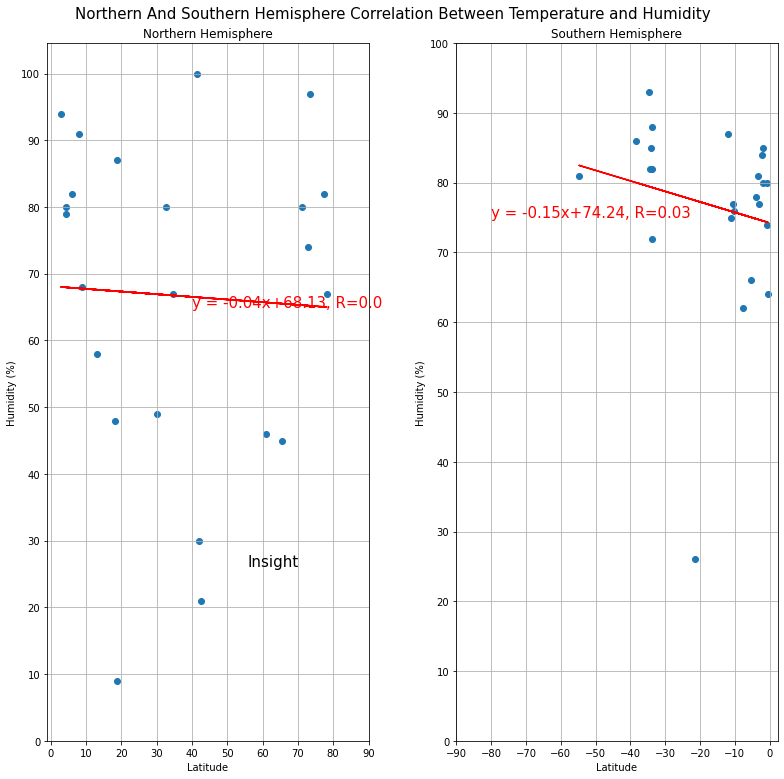

In [80]:
# Humidity (%) vs. Latitude broken by hemisphere

## North hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(0,100,10)

# Y axis will have 0-100% humidity
yticks = np.arange(0, 110, 10)

# Setting x and y for line
x_values = north_df['Latitude']
y_values = north_df['Humidity']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

# Plotting
fig, axes =plt.subplots(1,2,figsize=(11,11))

axes[0].scatter(x=north_df["Latitude"], y=north_df["Humidity"])
axes[0].grid()
axes[0].annotate(line_eq + ', R=' + str(round(r**2, 2)),(40,65), fontsize=15,color="red")
axes[0].plot(x_values, m*x_values + b, color ='r')
axes[0].set_xticks(xticks)
axes[0].set_yticks(yticks)
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Humidity (%)')
axes[0].set_title('Northern Hemisphere')

## South hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,10,10)

# Y axis will have 0-100% humidity
yticks = np.arange(0, 110, 10)

# Setting x and y for line
x_values = south_df['Latitude']
y_values = south_df['Humidity']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

axes[1].scatter(x=south_df["Latitude"], y=south_df["Humidity"])
axes[1].grid()
axes[1].annotate(line_eq + ', R=' + str(round(r**2, 2)),(-80,75), fontsize=15,color="red")
axes[1].plot(x_values, m*x_values + b, color ='r')
axes[1].set_xticks(xticks)
axes[1].set_yticks(yticks)
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Humidity (%)')
axes[1].set_title('Southern Hemisphere')

plt.suptitle ('Northern And Southern Hemisphere Correlation Between Temperature and Humidity', fontsize = 15)
plt.tight_layout()

# Adding an explanatory line for the graph
plt.annotate("Insight", xy=(-150,25), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'hemi_humi_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)

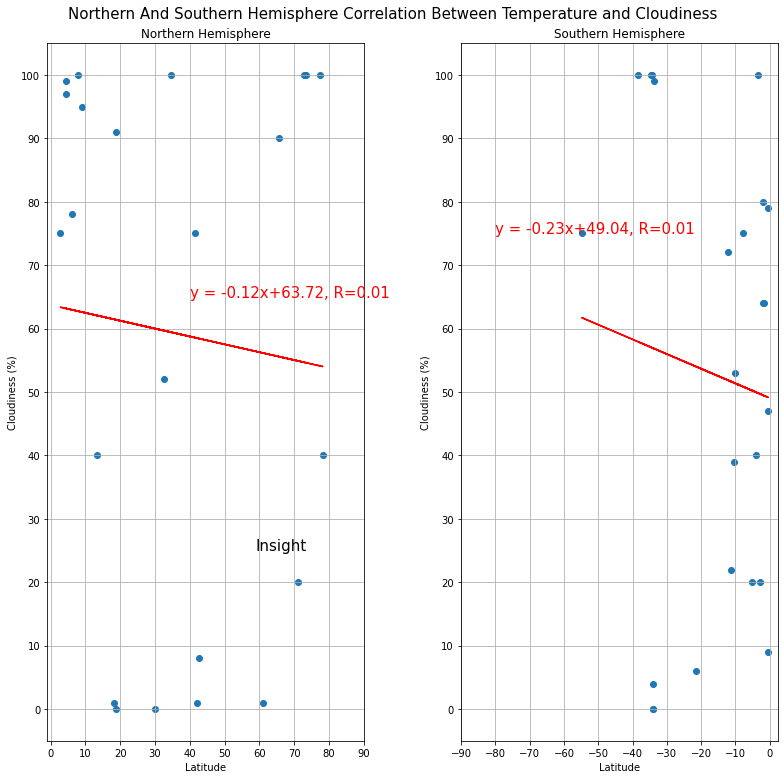

In [81]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude broken by hemisphere

## North hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(0,100,10)

# Y axis will have 0-100% cloudiness
yticks = np.arange(0, 110, 10)

# Setting x and y for line
x_values = north_df['Latitude']
y_values = north_df['Cloudiness']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

# Plotting
fig, axes =plt.subplots(1,2,figsize=(11,11))

axes[0].scatter(x=north_df["Latitude"], y=north_df["Cloudiness"])
axes[0].grid()
axes[0].annotate(line_eq + ', R=' + str(round(r**2, 2)),(40,65), fontsize=15,color="red")
axes[0].plot(x_values, m*x_values + b, color ='r')
axes[0].set_xticks(xticks)
axes[0].set_yticks(yticks)
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Cloudiness (%)')
axes[0].set_title('Northern Hemisphere')

## South hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,10,10)

# Y axis will have 0-100% humidity
yticks = np.arange(0, 110, 10)

# Setting x and y for line
x_values = south_df['Latitude']
y_values = south_df['Cloudiness']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

axes[1].scatter(x=south_df["Latitude"], y=south_df["Cloudiness"])
axes[1].grid()
axes[1].annotate(line_eq + ', R=' + str(round(r**2, 2)),(-80,75), fontsize=15,color="red")
axes[1].plot(x_values, m*x_values + b, color ='r')
axes[1].set_xticks(xticks)
axes[1].set_yticks(yticks)
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Cloudiness (%)')
axes[1].set_title('Southern Hemisphere')

plt.suptitle ('Northern And Southern Hemisphere Correlation Between Temperature and Cloudiness', fontsize = 15)
plt.tight_layout()

# Adding an explanatory line for the graph
plt.annotate("Insight", xy=(-150,25), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'hemi_cloud_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)

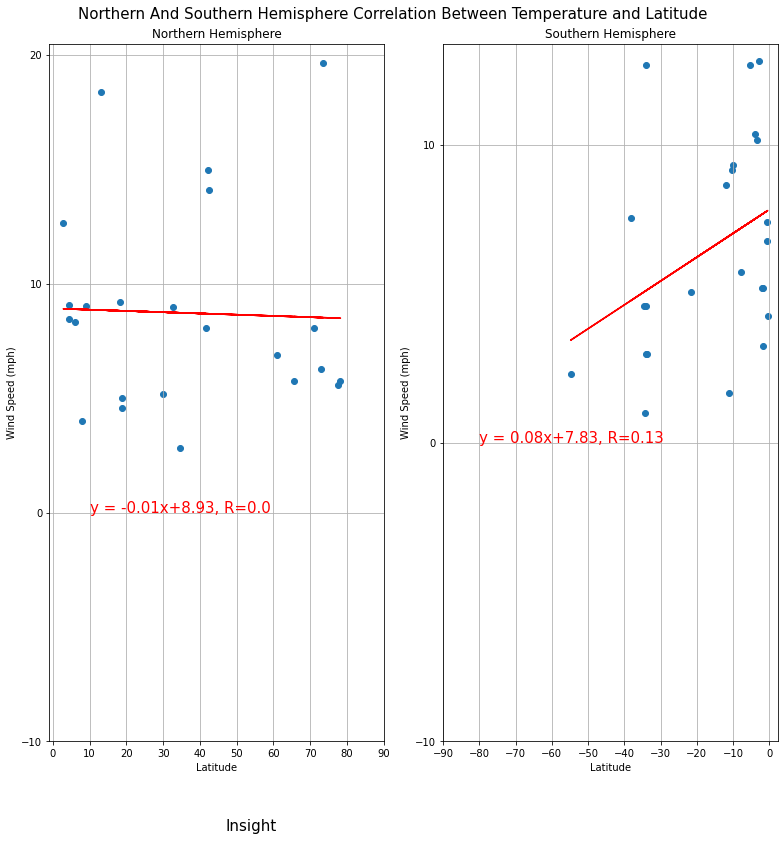

In [90]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude broken by hemisphere

## North hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(0,100,10)

# Y axis will contain max/min wind speed values rounded to the closest 10
min_temp = (round(clean_weather_df['Wind Speed (mph)'].min()/10, 0))*10 - 10
max_temp = (round(clean_weather_df['Wind Speed (mph)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp, 10)

# Setting x and y for line
x_values = north_df['Latitude']
y_values = north_df['Wind Speed (mph)']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

# Plotting
fig, axes =plt.subplots(1,2,figsize=(11,11))

axes[0].scatter(x=north_df["Latitude"], y=north_df["Wind Speed (mph)"])
axes[0].grid()
axes[0].annotate(line_eq + ', R=' + str(round(r**2, 2)),(10,0), fontsize=15,color="red")
axes[0].plot(x_values, m*x_values + b, color ='r')
axes[0].set_xticks(xticks)
axes[0].set_yticks(yticks)
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Wind Speed (mph)')
axes[0].set_title('Northern Hemisphere')

## South hemisphere

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,10,10)

# Y axis will contain max/min temp values rounded to the closest 10
min_temp = (round(south_df['Wind Speed (mph)'].min()/10,0))*10 - 10
max_temp = (round(south_df['Wind Speed (mph)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp, 10)

# Setting x and y for line
x_values = south_df['Latitude']
y_values = south_df['Wind Speed (mph)']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))

axes[1].scatter(x=south_df["Latitude"], y=south_df["Wind Speed (mph)"])
axes[1].grid()
axes[1].annotate(line_eq + ', R=' + str(round(r**2, 2)),(-80,0), fontsize=15,color="red")
axes[1].plot(x_values, m*x_values + b, color ='r')
axes[1].set_xticks(xticks)
axes[1].set_yticks(yticks)
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Wind Speed (mph)')
axes[1].set_title('Southern Hemisphere')

plt.suptitle ('Northern And Southern Hemisphere Correlation Between Temperature and Latitude', fontsize = 15)
plt.tight_layout()

# Adding an explanatory line for the graph
plt.annotate("Insight", xy=(-150,-13), annotation_clip=False, fontsize=15)

# Saving to png
filename = 'hemi_wind_lat.png'
path = os.path.join('plot_images', filename)
plt.savefig(path)